# 🌱 ESG Stock Event Study — Mean-Adjusted Model

This notebook loads the **daily-updated datasets** produced by the GitHub Actions pipeline and computes an event study using a **mean-adjusted model**:

- **Estimation window:** τ ∈ [-120, -20] days before the event  
- **Event window:** τ ∈ [-5, +5] days around the event  
- **Expected return:** mean return of the stock over the estimation window  
- **AR:** abnormal return = actual return − expected return  
- **AAR:** average abnormal return across events for each τ  
- **CAR:** cumulative abnormal return across τ


In [11]:
import os
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from IPython.display import display

# ---------- TZ/Date helpers ----------
def to_naive_datetime_index(idx) -> pd.DatetimeIndex:
    """Ensure DatetimeIndex is tz-naive and normalized to date."""
    idx = pd.to_datetime(idx, errors="coerce", utc=True)
    idx = idx.tz_convert(None)
    return idx.normalize()

def to_naive_datetime_series(s: pd.Series) -> pd.Series:
    """Ensure datetime series is tz-naive and normalized to date."""
    s = pd.to_datetime(s, errors="coerce", utc=True)
    return s.dt.tz_convert(None).dt.normalize()

def align_to_trading_day(dates: pd.Series, trading_index: pd.DatetimeIndex, method="next") -> pd.Series:
    """
    Align event dates to trading days so tau=0 is a valid trading day.
    method: 'next' (common) → first trading day not earlier than the raw date
            'prev' → last trading day not later than the raw date
    """
    td = pd.Index(pd.to_datetime(trading_index).normalize().unique()).sort_values()
    normalized = pd.to_datetime(dates).dt.normalize()
    out = []
    for d in normalized:
        idx = td.get_indexer([d], method="backfill" if method=="next" else "ffill")
        if idx[0] == -1:
            out.append(td[0] if method=="next" else td[-1])
        else:
            out.append(td[idx[0]])
    return pd.to_datetime(out)

# ---------- Bundle loader ----------
def load_latest_bundle():
    """
    Load prices/returns/events (and optional panel) from data/latest/*.
    - Normalize dates (tz-naive)
    - Derive event_date from published_utc if needed
    - Filter events to tickers present in both prices & returns
    - Deduplicate events by (ticker, event_date)
    """
    CANDIDATES = [
        "data/latest",
        "data-science-projects-starter/data-science-projects/esg-stock-event-study/data/latest",
    ]
    DATA_LATEST = next((p for p in CANDIDATES if os.path.exists(p)), None)
    if DATA_LATEST is None:
        raise FileNotFoundError("Could not find data/latest. Run the pipeline or adjust path.")

    prices_path  = os.path.join(DATA_LATEST, "prices_latest.csv")
    returns_path = os.path.join(DATA_LATEST, "returns_latest.csv")
    events_path  = os.path.join(DATA_LATEST, "esg_events_latest.csv")
    panel_path   = os.path.join(DATA_LATEST, "events_prices_panel.csv")

    # Load prices & returns
    prices  = pd.read_csv(prices_path, index_col=0)
    returns = pd.read_csv(returns_path, index_col=0)
    prices.index  = to_naive_datetime_index(prices.index)
    returns.index = to_naive_datetime_index(returns.index)
    prices  = prices.apply(pd.to_numeric, errors="coerce")
    returns = returns.apply(pd.to_numeric, errors="coerce")

    # Load events
    if os.path.exists(events_path):
        events = pd.read_csv(events_path)
    else:
        events = pd.DataFrame(columns=["ticker", "event_date"])

    if "event_date" in events.columns:
        events["event_date"] = to_naive_datetime_series(events["event_date"])
    elif "published_utc" in events.columns:
        events["event_date"] = to_naive_datetime_series(events["published_utc"])
    else:
        events["event_date"] = pd.NaT

    if "ticker" not in events.columns:
        events["ticker"] = ""
    events["ticker"] = events["ticker"].astype(str)

    tickers_in_data = set(prices.columns).intersection(returns.columns)
    events = events[events["ticker"].isin(tickers_in_data)].copy()
    events = (events
              .dropna(subset=["event_date"])
              .drop_duplicates(subset=["ticker","event_date"], keep="first")
              .reset_index(drop=True))

    # Load optional panel
    panel = None
    if os.path.exists(panel_path):
        try:
            panel = pd.read_csv(panel_path)
            if "date" in panel.columns:
                panel["date"] = to_naive_datetime_series(panel["date"])
            if "event_date" in panel.columns:
                panel["event_date"] = to_naive_datetime_series(panel["event_date"])
        except Exception:
            panel = None

    print(f"[INFO] prices:  shape={prices.shape}, dates {prices.index.min()} → {prices.index.max()}")
    print(f"[INFO] returns: shape={returns.shape}, dates {returns.index.min()} → {returns.index.max()}")
    print(f"[INFO] events:  rows={len(events)} (after align & dedup)")
    if panel is not None:
        print(f"[INFO] panel:  rows={len(panel)} (prebuilt)")

    return prices, returns, events, panel



## 1) Prepare returns aligned to each event
We'll compute each event's **estimation window** ([-120, -20]) using the global `returns_latest.csv`,
then calculate **AR** within the event window ([-5, +5]).

In [12]:
# ---------- Event study setup ----------
EST_WIN = (-120, -20)   # estimation window (days relative to event)
EVT_WIN = (-5, 5)       # event window (days relative to event)
MIN_EST_OBS = 30        # minimum required observations in estimation window

def mean_adjusted_expected(ser: pd.Series, event_date: pd.Timestamp,
                           est_win=EST_WIN, min_obs=MIN_EST_OBS) -> float:
    """
    Compute expected return using the mean return over the estimation window.
    Returns NaN if not enough observations.
    """
    start = event_date + timedelta(days=est_win[0])
    end   = event_date + timedelta(days=est_win[1])
    s = ser.loc[(ser.index >= start) & (ser.index <= end)]
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.size < min_obs:
        return np.nan
    return float(s.mean())

def build_event_ar_table(returns_df: pd.DataFrame, events_df: pd.DataFrame,
                         evt_win=EVT_WIN, align_method="next"):
    """
    Construct event abnormal return (AR) table.
    Output columns: date, ticker, event_date, tau, ret, exp_ret, ar
    """
    rows = []
    r = returns_df.copy()
    r.index = to_naive_datetime_index(r.index)

    ev = events_df.copy()
    ev["event_date"] = to_naive_datetime_series(ev["event_date"])
    ev = ev.dropna(subset=["event_date"])
    if "ticker" not in ev.columns:
        ev["ticker"] = ""
    ev["ticker"] = ev["ticker"].astype(str)
    ev = ev.drop_duplicates(subset=["ticker", "event_date"]).reset_index(drop=True)

    # Align events to trading day so tau=0 corresponds to a real trading day
    ev["event_date"] = align_to_trading_day(ev["event_date"], r.index, method=align_method)

    for _, e in ev.iterrows():
        tic = e["ticker"]
        if tic not in r.columns:
            continue
        event_date = e["event_date"]

        mu = mean_adjusted_expected(r[tic], event_date, est_win=EST_WIN, min_obs=MIN_EST_OBS)
        if np.isnan(mu):
            continue

        start = event_date + timedelta(days=evt_win[0])
        end   = event_date + timedelta(days=evt_win[1])
        seg = r.loc[(r.index >= start) & (r.index <= end), [tic]].copy().dropna()
        if seg.empty:
            continue

        seg = seg.rename(columns={tic: "ret"})
        seg["date"] = seg.index
        seg["tau"] = (seg["date"] - event_date).dt.days
        seg["ticker"] = tic
        seg["event_date"] = event_date
        seg["exp_ret"] = mu
        seg["ar"] = seg["ret"] - seg["exp_ret"]
        rows.append(seg[["date", "ticker", "event_date", "tau", "ret", "exp_ret", "ar"]])

    if not rows:
        return pd.DataFrame(columns=["date","ticker","event_date","tau","ret","exp_ret","ar"])
    out = pd.concat(rows, ignore_index=True)
    return out.sort_values(["ticker", "event_date", "tau"]).reset_index(drop=True)

def aggregate_aar_car_with_t(event_ar_df: pd.DataFrame):
    """
    Compute:
      - AAR (average abnormal return)
      - N (number of events)
      - sd (cross-sectional standard deviation)
      - t (test statistic)
      - CAR (cumulative abnormal return)
    """
    if event_ar_df.empty:
        return (pd.DataFrame(columns=["tau","AAR","N","sd","t"]),
                pd.DataFrame(columns=["tau","CAR"]))
    stats = (
        event_ar_df
        .groupby("tau")["ar"]
        .agg(AAR="mean", sd=lambda x: x.std(ddof=1), N="count")
        .reset_index()
        .sort_values("tau")
    )
    denom = stats["sd"] / np.sqrt(stats["N"].where(stats["N"]>0, np.nan))
    stats["t"] = stats["AAR"] / denom.replace(0, np.nan)
    stats.replace([np.inf, -np.inf], np.nan, inplace=True)

    car = stats[["tau","AAR"]].copy()
    car["CAR"] = car["AAR"].cumsum()
    return stats[["tau","AAR","N","sd","t"]], car[["tau","CAR"]]



## 2) Compute AAR and CAR

In [13]:
# Load data bundle
prices, returns, events, panel = load_latest_bundle()

# Build per-event abnormal returns table
event_ar = build_event_ar_table(
    returns_df=returns,
    events_df=events,
    evt_win=EVT_WIN,
    align_method="next",   # align event_date to the next trading day
)

# Aggregate AAR / CAR (+ t-stats)
aar, car = aggregate_aar_car_with_t(event_ar)

# Quick logs
uniq_events = event_ar[["ticker","event_date"]].drop_duplicates().shape[0] if not event_ar.empty else 0
print(f"[INFO] AR table: rows={len(event_ar)}, unique events={uniq_events}")
print(f"[INFO] AAR rows: {len(aar)}, CAR rows: {len(car)}")

# Peek tables
display(event_ar.head(10))
display(aar.head(10))
display(car.head(10))


[INFO] prices:  shape=(521, 5), dates 2023-09-01 00:00:00 → 2025-09-30 00:00:00
[INFO] returns: shape=(520, 5), dates 2023-09-05 00:00:00 → 2025-09-30 00:00:00
[INFO] events:  rows=19 (after align & dedup)
[INFO] panel:  rows=0 (prebuilt)
[INFO] AR table: rows=104, unique events=15
[INFO] AAR rows: 11, CAR rows: 11


,date,ticker,event_date,tau,ret,exp_ret,ar
0,2025-09-22,AAPL,2025-09-25,-3,0.043096,0.002680,0.040415
1,2025-09-23,AAPL,2025-09-25,-2,-0.006443,0.002680,-0.009124
2,2025-09-24,AAPL,2025-09-25,-1,-0.008332,0.002680,-0.011013
3,2025-09-25,AAPL,2025-09-25,0,0.018073,0.002680,0.015393
4,2025-09-26,AAPL,2025-09-25,1,-0.005489,0.002680,-0.008169
5,2025-09-29,AAPL,2025-09-25,4,-0.004032,0.002680,-0.006712
6,2025-09-30,AAPL,2025-09-25,5,0.000786,0.002680,-0.001894
7,2025-09-22,AAPL,2025-09-26,-4,0.043096,0.002704,0.040392
8,2025-09-23,AAPL,2025-09-26,-3,-0.006443,0.002704,-0.009147
9,2025-09-24,AAPL,2025-09-26,-2,-0.008332,0.002704,-0.011036


,tau,AAR,N,sd,t
0,-5,0.005306,14,0.024275,0.817790
1,-4,-0.003861,15,0.026870,-0.556548
2,-3,0.012133,12,0.022689,1.852487
3,-2,0.001503,7,0.020556,0.193481
4,-1,-0.003371,12,0.020744,-0.562957
5,0,0.003739,19,0.017956,0.907616
6,1,-0.005060,11,0.020101,-0.834897
7,2,0.023271,2,0.023092,1.425167
8,3,0.001407,3,0.007074,0.344579
9,4,0.001200,5,0.005439,0.493512


,tau,CAR
0,-5,0.005306
1,-4,0.001444
2,-3,0.013577
3,-2,0.015081
4,-1,0.011709
5,0,0.015448
6,1,0.010388
7,2,0.033659
8,3,0.035067
9,4,0.036267


## 3) Plot AAR and CAR

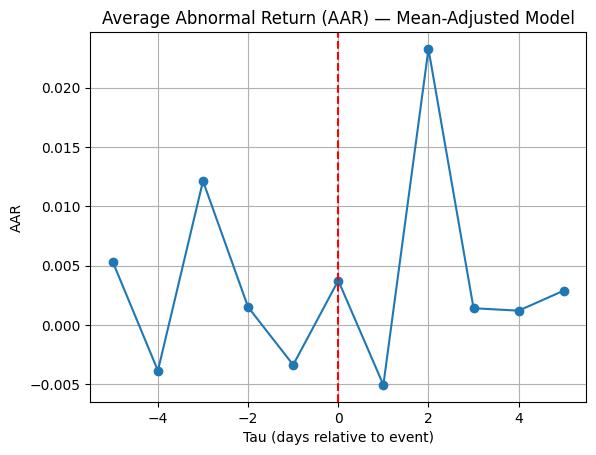

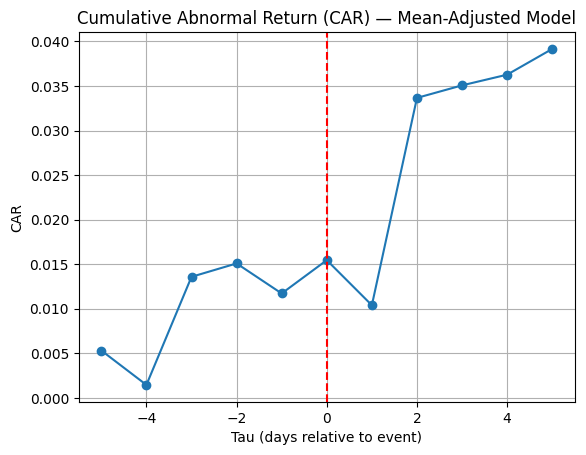

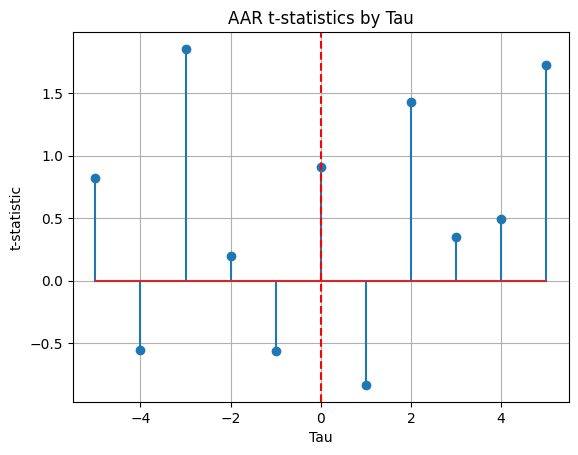

In [14]:
# Plot Average Abnormal Return (AAR)
if not aar.empty:
    plt.figure()
    plt.plot(aar["tau"], aar["AAR"], marker="o")
    plt.axvline(0, linestyle="--", color="red")
    plt.title("Average Abnormal Return (AAR) — Mean-Adjusted Model")
    plt.xlabel("Tau (days relative to event)")
    plt.ylabel("AAR")
    plt.grid(True)
    plt.show()

# Plot Cumulative Abnormal Return (CAR)
if not car.empty:
    plt.figure()
    plt.plot(car["tau"], car["CAR"], marker="o")
    plt.axvline(0, linestyle="--", color="red")
    plt.title("Cumulative Abnormal Return (CAR) — Mean-Adjusted Model")
    plt.xlabel("Tau (days relative to event)")
    plt.ylabel("CAR")
    plt.grid(True)
    plt.show()

# Plot AAR t-statistics
if not aar.empty:
    plt.figure()
    plt.stem(aar["tau"], aar["t"])   # no use_line_collection for compatibility
    plt.axvline(0, linestyle="--", color="red")
    plt.title("AAR t-statistics by Tau")
    plt.xlabel("Tau")
    plt.ylabel("t-statistic")
    plt.grid(True)
    plt.show()


## 4) Inspect one example event

In [15]:
# Show one example event window (±5 days = 11 rows if full)
if not event_ar.empty:
    example = (
        event_ar.sort_values(["event_date","ticker","tau"])
                .groupby(["ticker","event_date"], as_index=False, sort=False)
                .head(11)
    )
    print("[INFO] Example event window (first 20 rows):")
    display(example.head(20))
else:
    print("No event AR table generated. Check ESG events or adjust tickers/keywords.")

# How many events contributed to each tau?
if not event_ar.empty:
    tau_counts = event_ar.groupby("tau")["ar"].count().rename("N").reset_index()
    print("[INFO] Number of events per tau:")
    display(tau_counts)

# Optional: export results to CSV for reporting
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

if not event_ar.empty:
    event_ar.to_csv(os.path.join(OUTPUT_DIR, "event_ar_table.csv"), index=False)
if not aar.empty:
    aar.to_csv(os.path.join(OUTPUT_DIR, "aar_table.csv"), index=False)
if not car.empty:
    car.to_csv(os.path.join(OUTPUT_DIR, "car_table.csv"), index=False)

print("[INFO] Saved CSVs to:", os.path.abspath(OUTPUT_DIR))


[INFO] Example event window (first 20 rows):


,date,ticker,event_date,tau,ret,exp_ret,ar
46,2025-09-19,MSFT,2025-09-24,-5,0.018645,0.001795,0.016850
47,2025-09-22,MSFT,2025-09-24,-2,-0.006719,0.001795,-0.008514
48,2025-09-23,MSFT,2025-09-24,-1,-0.010147,0.001795,-0.011941
49,2025-09-24,MSFT,2025-09-24,0,0.001807,0.001795,0.000012
50,2025-09-25,MSFT,2025-09-24,1,-0.006116,0.001795,-0.007911
51,2025-09-26,MSFT,2025-09-24,2,0.008737,0.001795,0.006942
52,2025-09-29,MSFT,2025-09-24,5,0.006139,0.001795,0.004345
64,2025-09-19,TSLA,2025-09-24,-5,0.022118,0.000576,0.021542
65,2025-09-22,TSLA,2025-09-24,-2,0.019105,0.000576,0.018529
66,2025-09-23,TSLA,2025-09-24,-1,-0.019253,0.000576,-0.019829


[INFO] Number of events per tau:


,tau,N
0,-5,14
1,-4,15
2,-3,12
3,-2,7
4,-1,12
5,0,19
6,1,11
7,2,2
8,3,3
9,4,5


[INFO] Saved CSVs to: /workspaces/data-science-projects/data-science-projects-starter/data-science-projects/esg-stock-event-study/outputs
